<a href="https://colab.research.google.com/github/ImJongHwan/practice-ml-nlp/blob/main/12_tagging_task/2_Part_of_speech_Tagging_using_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 양방향 LSTM를 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

https://wikidocs.net/33532

## 품사 태깅 데이터에 대한 이해와 전처리

In [4]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [5]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print('품사 태깅이 된 문장 개수: ', len(tagged_sentences))

품사 태깅이 된 문장 개수:  3914


In [6]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [8]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  pos_tags.append(list(tag_info))

In [9]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [10]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


샘플의 최대 길이: 271
샘플의 평균 길이: 25.722024


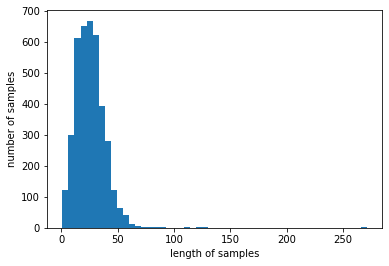

In [11]:
print('샘플의 최대 길이: %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이: %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [13]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [14]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print(f'단어 집합의 크기: {vocab_size}')
print(f'태깅 정보 집합의 크기: {tag_size}')

단어 집합의 크기: 11388
태깅 정보 집합의 크기: 47


In [16]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [17]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [18]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [20]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150)


## 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=7, validation_data=(X_test, y_test))

Epoch 1/7
25/25 [==============================] - 58s 2s/step - loss: 0.5923 - accuracy: 0.1406 - val_loss: 0.5170 - val_accuracy: 0.1725
Epoch 2/7
25/25 [==============================] - 35s 1s/step - loss: 0.5041 - accuracy: 0.1862 - val_loss: 0.4814 - val_accuracy: 0.2273
Epoch 3/7
25/25 [==============================] - 33s 1s/step - loss: 0.4559 - accuracy: 0.3584 - val_loss: 0.4080 - val_accuracy: 0.4400
Epoch 4/7
25/25 [==============================] - 33s 1s/step - loss: 0.3506 - accuracy: 0.5020 - val_loss: 0.2848 - val_accuracy: 0.5773
Epoch 5/7
25/25 [==============================] - 33s 1s/step - loss: 0.2303 - accuracy: 0.6815 - val_loss: 0.1797 - val_accuracy: 0.7606
Epoch 6/7
25/25 [==============================] - 32s 1s/step - loss: 0.1345 - accuracy: 0.8389 - val_loss: 0.1087 - val_accuracy: 0.8727
Epoch 7/7
25/25 [==============================] - 34s 1s/step - loss: 0.0772 - accuracy: 0.9146 - val_loss: 0.0752 - val_accuracy: 0.8988


In [23]:
print('\n테스트 정확도: %.4f' % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 4s 170ms/step - loss: 0.0752 - accuracy: 0.8988

테스트 정확도: 0.8988


In [25]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10
y_predicated = model.predict(np.array([X_test[i]]))
y_predicated = np.argmax(y_predicated, axis=-1)

print(f'{"단어":15}|{"실제값":5}|{"예측값"}')
print(35 * "-")

for word, tag, pred in zip(X_test[i], y_test[i], y_predicated[0]):
  if word != 0:
    print(f'{index_to_word[word]:17} {index_to_tag[tag].upper():7} {index_to_tag[pred].upper()}')

단어             |실제값  |예측값
-----------------------------------
in                IN      IN
addition          NN      NN
,                 ,       ,
buick             NNP     NNP
is                VBZ     VBZ
a                 DT      DT
relatively        RB      RB
respected         VBN     VBN
nameplate         NN      NN
among             IN      IN
american          NNP     NNP
express           NNP     NNP
card              NN      NN
holders           NNS     NNS
,                 ,       ,
says              VBZ     VBZ
0                 -NONE-  -NONE-
*t*-1             -NONE-  -NONE-
an                DT      DT
american          NNP     NNP
express           NNP     NNP
spokeswoman       NN      NN
.                 .       .
